<a href="https://colab.research.google.com/github/Georgemburu/MACHINE-LEARNING/blob/master/Spanish_to_English_ML_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x


In [110]:
from __future__ import print_function, absolute_import,division,unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

print(tf.__version__)

2.0.0


In [0]:
# DOWNLOAD DATASET
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = os.path.dirname(path_to_zip)+'/spa-eng/spa.txt'

In [112]:
path_to_file

'/root/.keras/datasets/spa-eng/spa.txt'

In [113]:
import pandas as pd
data = pd.read_csv(path_to_file, delimiter='\t')
data

,Go.,Ve.
0,Go.,Vete.
1,Go.,Vaya.
2,Go.,Váyase.
3,Hi.,Hola.
4,Run!,¡Corre!
...,...,...
118958,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118959,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118960,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118961,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


In [0]:
# convert the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) 
    if unicodedata.category(c) != 'Mn'
  )

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.rstrip().strip()

  # Add a start and end token
  w = '<start> '+ w + ' <end>'
  return w


In [115]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))


<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
#. Remove the accents
#. Clean the sentences
#. Return word pairs in format: [ENGLISH, SPANISH]
def create_dataset(path,num_examples):
  lines = io.open(path,encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
  return zip(*word_pairs)

In [117]:
en,sp = create_dataset(path_to_file,None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters=''
  )
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer


In [0]:
def load_dataset(path,num_examples=None):
  # Creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, input_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, input_lang_tokenizer, targ_lang_tokenizer


In [0]:
# LIMIT SIZE OF DATASET
num_examples = 30000
input_tensor,target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,num_examples)

# calculate the max len of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [122]:
# split training and validation sets using 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print([len(l) for l in [input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val]])

[24000, 6000, 24000, 6000]


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d --------> %s" % (t, lang.index_word[t]))

In [124]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])


Input Language; index to word mapping
1 --------> <start>
28 --------> eso
513 --------> suena
56 --------> bien
3 --------> .
2 --------> <end>

Target Language; index to word mapping
1 --------> <start>
20 --------> that
518 --------> sounds
107 --------> right
3 --------> .
2 --------> <end>


In [0]:
# Create a tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [126]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [0]:
# WRITE THE ENCODER AND DECODER MODEL

class Encoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
    

In [128]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Sample input
sample_hidden = encoder.initialize_hidden_state()
print('Sample hidden', sample_hidden)

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print('\n')
print('Sample Output->',sample_output)
print('\n')
print('sample Hidden->',sample_hidden)

Sample hidden tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 1024), dtype=float32)
Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


Sample Output-> tf.Tensor(
[[[ 1.47458110e-02 -1.10041304e-03  3.44628538e-03 ...  6.43348973e-03
    1.11791147e-02 -9.34091583e-03]
  [ 1.13593973e-02  8.13136983e-04 -3.17599624e-03 ...  1.43607648e-03
    5.55685023e-03 -1.22272335e-02]
  [ 8.73718597e-03  1.40009145e-03 -1.17216902e-02 ... -4.24727378e-03
   -5.74014441e-04 -3.12776072e-03]
  ...
  [-1.82622578e-02  1.03854947e-02  1.24956667e-02 ...  6.93128537e-03
    1.02175120e-02 -3.51994019e-03]
  [-1.83877572e-02  1.04637071e-02  1.25309909e-02 ...  6.97436836e-03
    1.03303837e-02 -3.53985326e-03]
  [-1.84680279e-02  1.05035417e-02  1.25450231e-02 ...  6.99867774e-03
    1.04045

In [0]:
# BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,  units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size,max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)
    ))
    # attenton_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score,axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [130]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
# DECODER
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size,embedding_dim,dec_units,batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self,x,hidden,enc_output):
    # enc_output.shape == (batch_size,max_length,hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size,1,embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # Passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1,output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights


In [132]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output,_,_ = decoder(tf.random.uniform((BATCH_SIZE,1)),
                                    sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [0]:
# OPTIMIZER AND LOSS FUNCTION
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

def loss_function(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real,pred)

  mask = tf.cast(mask,dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [136]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.6626
Epoch 1 Batch 100 Loss 2.1829
Epoch 1 Batch 200 Loss 1.8334
Epoch 1 Batch 300 Loss 1.8171
Epoch 1 Loss 2.0375
Time taken for 1 epoch 92.3559775352478 sec

Epoch 2 Batch 0 Loss 1.4489
Epoch 2 Batch 100 Loss 1.3550
Epoch 2 Batch 200 Loss 1.5071
Epoch 2 Batch 300 Loss 1.2632
Epoch 2 Loss 1.4131
Time taken for 1 epoch 74.08428716659546 sec

Epoch 3 Batch 0 Loss 1.1852
Epoch 3 Batch 100 Loss 1.0946
Epoch 3 Batch 200 Loss 0.9818
Epoch 3 Batch 300 Loss 0.9772
Epoch 3 Loss 1.0039
Time taken for 1 epoch 73.46191716194153 sec

Epoch 4 Batch 0 Loss 0.7009
Epoch 4 Batch 100 Loss 0.6456
Epoch 4 Batch 200 Loss 0.7105
Epoch 4 Batch 300 Loss 0.6422
Epoch 4 Loss 0.6839
Time taken for 1 epoch 73.54629635810852 sec

Epoch 5 Batch 0 Loss 0.4529
Epoch 5 Batch 100 Loss 0.4205
Epoch 5 Batch 200 Loss 0.4246
Epoch 5 Batch 300 Loss 0.4236
Epoch 5 Loss 0.4682
Time taken for 1 epoch 73.46191501617432 sec

Epoch 6 Batch 0 Loss 0.2991
Epoch 6 Batch 100 Loss 0.3047
Epoch 6 Batch 200 Loss 

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [140]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


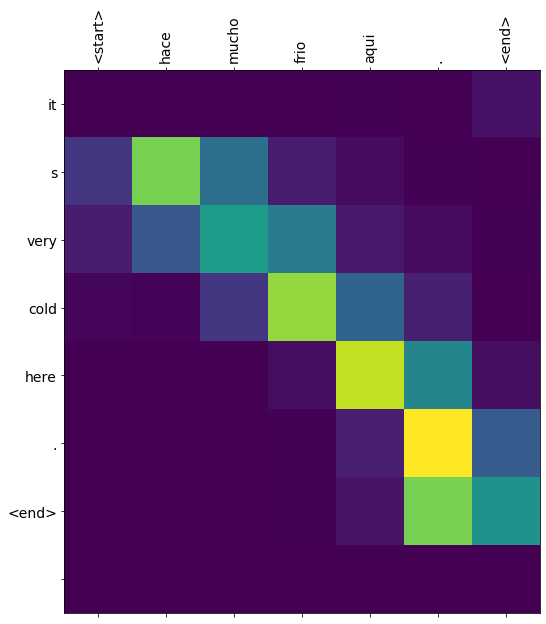

In [141]:
# TRANSLATE
translate(u'hace mucho frio aqui.')
